In [227]:
%matplotlib inline
import os 
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon
import statsmodels.api as sm
pd.options.display.max_columns = 99
import statsmodels.formula.api as smf
import math 
import scipy.stats as ss
plt.rcParams['font.family'] = 'Myriad Pro'
sns.set_style('white')

clinical_dir  = '/Users/kanaan/SCR/Dataframes_20150820/DF_clinical/'
datadir = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Presentations/2016_06_ESSTS_QSM'

chimeasures = [ #'Age',
             #'SNR' , 'CNR' , 'FBER',  'QI1', 
             'R_Caud', 'L_Caud', 'R_Puta', 'L_Puta', 'R_Pall', 'L_Pall',
              'R_Amyg', 'L_Amyg', 'R_Hipp', 'L_Hipp', 'R_Accu', 'L_Accu',
              'R_Thal', 'L_Thal', 'L_Insula', 'R_Insula', 'L_Cingulum', 'R_Cingulum', 
              'L_ant_Insula', 'R_ant_Insula', 'L_inf_Insula', 'R_inf_Insula',  'L_sup_Insula', 'R_sup_Insula', 
              'L_ant_Cingulum', 'R_ant_Cingulum', 'L_ant_mid_Cingulum', 'R_ant_mid_Cingulum',
              'L_post_mid_Cingulum', 'R_post_mid_Cingulum', 'L_post_dors_Cingulum',
             'R_post_dors_Cingulum','L_post_vent_Cingulum', 'R_post_vent_Cingulum', 
             'L_RN', 'R_RN', 'L_STN', 'R_STN', 'L_SN', 'R_SN',
             'Caud', 'Puta', 'Pall', 'Thal', 'Accu', 'Amyg', 'Hipp', 'RN', 'SN','STN',
             'Insula', 'ant_Insula', 'inf_Insula', 'sup_Insula',
             'Cingulum', 'post_mid_Cingulum', 'post_dors_Cingulum','post_vent_Cingulum', 'ant_Cingulum', 'ant_mid_Cingulum',
             'BrainStem', 'BasalGanglia'
            ]
clinicals  = ['YGTSS', 'RVTRS', 'PUTS', #'YBOCS', 'OCI', 'CAARS', 'QOL', 'QOLs', 'BDI', 
              'Ferritin']
#clinicals = ['p_' + measure for measure in clinicals]

drop_c =  []
drop_p = ['NL2P', 'STDP', 'HSPP', 'CB4P', 'SA5U']  # Based on quality control of MP2RAGE_UNI 

In [228]:
def get_clinical(df, pop_name):
    clinical_df = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s.csv'%pop_name), index_col=0)
    
    for subject in df.index:
        if subject in clinical_df.index:
            df.ix[subject, 'YGTSS']             = clinical_df.loc[subject]['YGTSS_Total_Tic_Score']
            df.ix[subject, 'RVTRS']             = clinical_df.loc[subject]['RVTRS']
            df.ix[subject, 'PUTS']              = clinical_df.loc[subject]['puts']
            df.ix[subject, 'YBOCS']             = clinical_df.loc[subject]['YBOCS_Totalscore_Items_1to10']
            df.ix[subject, 'OCI']               = clinical_df.loc[subject]['OCIR_total score']
            df.ix[subject, 'CAARS' ]            = clinical_df.loc[subject]['CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score']
            df.ix[subject, 'DSM4']              = clinical_df.loc[subject]['DSM4_clinically_significant_ADHD']
            df.ix[subject, 'QOL']               = clinical_df.loc[subject]['qol_scale']
            df.ix[subject, 'QOLs']              = clinical_df.loc[subject]['qol_score']
            df.ix[subject, 'BDI']               = clinical_df.loc[subject]['BDI12']
            df.ix[subject, 'Ferritin']          = clinical_df.loc[subject]['Ferritin']
    
    return df, clinical_df

controls_a = pd.read_csv(os.path.join(datadir, 'controls_a.csv'), index_col = 0)
patients_a = pd.read_csv(os.path.join(datadir, 'patients_a.csv'), index_col = 0)
Xcontrols_a, controls_a_clinical = get_clinical(controls_a, 'controls_a')
Xpatients_a, patients_a_clinical = get_clinical(patients_a, 'patients_a')

In [369]:
def return_correlation_tables(data, regressors, metabolites, clinical_measures, model_type):
    
    print 'Bonferroni threshold =',  0.05/ (len(clinical_measures) * len(metabolites) )
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    
    def make_multiple_reg(data, x, y):
        
        df = pd.concat([df_reg, data[x], data[y]], axis=1)
        
        if model_type == 'linear':
            formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
            model   = smf.ols(formula=formula, data= df)
            result = model.fit() 
            p_val  = np.round(result.pvalues[1], 7)
            pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 7) , result.params[1])
        
        elif model_type == 'nonlinear':
                pcor, p_val  = ss.spearmanr(df[metabolite], df[clinical])
        if p_val < 0.1:
            print x, y, 'P_val=', p_val, 'R =', pcor
        return pcor, p_val
    
    stats_df = pd.DataFrame(index = clinical_measures,  columns=metabolites)   
    
    for clinical in clinical_measures:
        for metabolite in metabolites:
            p_cor, p_val = make_multiple_reg(data,  clinical, metabolite )
            stats_df.loc['%s'%clinical][metabolite] = np.round(p_val,7)
    return stats_df


def make_fdr(df):
    fdr = pd.DataFrame()
    for i in df.index:
        for c in df.columns:
            fdr.ix['%s_%s'%(i,c),'p'] = df.loc[i][c]

    fdr = fdr.sort('p')
    
    n_comparisons = len(fdr.index)
    for i, corr in enumerate(fdr.index):
        fdr.ix[corr, 'FDR_threshold'] = np.round((0.05 * (i + 1.) / n_comparisons), 9)
        
    return fdr

def plot_partial_correlation(data, x, y,  regressors = None, color = None, annotate = None, fig_name = None, 
                             dpi = 100, labels = True, jitter = None):
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    df = pd.concat([df_reg, data[x], data[y]], axis=1).dropna()
    
    # inititlize grid and plot regression and margins 
    grid = sns.JointGrid(x, y, data=df)#, size=size, ratio=ratio, space=space, #xlim=xlim, ylim=ylim), xlim=xlim, ylim=ylim
    grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, color = color, x_partial = df[regressors], y_jitter = jitter)
    if labels:
        grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels(None,None)
        
    ## calculate regression parameters 
    
    formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 7)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 7) , result.params[1])
    
    if annotate:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
                      
    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)



In [371]:
pat = return_correlation_tables(Xpatients_a.drop(drop_p + ['YU1P','CM5P'],axis=0),['Gender', 'FBER', 'SNR', 'SNR'], chimeasures, clinicals,
                                model_type = 'nonlinear')

Bonferroni threshold = 0.000201612903226
YGTSS R_Amyg P_val= 0.0500087188544 R = -0.482130001448
YGTSS R_Insula P_val= 0.0856499599738 R = -0.429108031979
YGTSS R_inf_Insula P_val= 0.0347203466785 R = -0.514189796941
YGTSS R_sup_Insula P_val= 0.0166855379026 R = -0.570910973581
YGTSS R_post_vent_Cingulum P_val= 0.0461009599383 R = -0.489528415792
YGTSS Amyg P_val= 0.079810325525 R = -0.436506446324
YGTSS sup_Insula P_val= 0.0268544090094 R = -0.535151970917
RVTRS R_Caud P_val= 0.0903716543562 R = 0.423388543647
Ferritin L_Amyg P_val= 0.061113371302 R = -0.463235294118
Ferritin L_Accu P_val= 0.0940176797007 R = -0.419117647059
Ferritin L_ant_Cingulum P_val= 0.0203705866245 R = -0.55637254902
Ferritin R_ant_Cingulum P_val= 0.0387210488787 R = -0.504901960784
Ferritin R_post_dors_Cingulum P_val= 0.056594108797 R = -0.470588235294
Ferritin Amyg P_val= 0.0496215896423 R = -0.482843137255
Ferritin ant_Cingulum P_val= 0.0355265241169 R = -0.512254901961


In [231]:
make_fdr(pat)

,p,FDR_threshold
YGTSS_sup_Insula,0.010098,0.000202
YGTSS_R_sup_Insula,0.016140,0.000403
Ferritin_L_ant_Cingulum,0.035659,0.000605
YGTSS_L_sup_Insula,0.047083,0.000806
YGTSS_R_Amyg,0.047562,0.001008
Ferritin_ant_Cingulum,0.048674,0.001210
Ferritin_Amyg,0.052690,0.001411
YGTSS_R_post_vent_Cingulum,0.055736,0.001613
Ferritin_R_ant_Cingulum,0.060315,0.001815
PUTS_L_STN,0.060835,0.002016


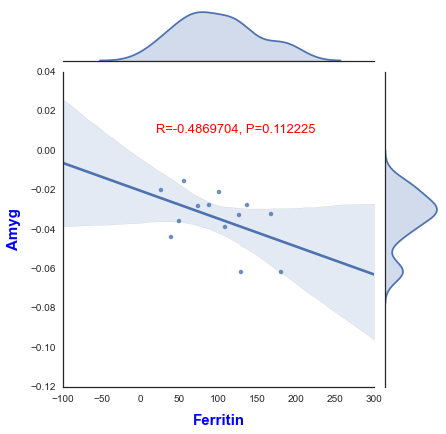

In [185]:
plot_partial_correlation(data = Xpatients_a.drop(drop_p,axis=0), x = 'Ferritin', y='Amyg',
                         regressors=['Age', 'Gender'], 
                         color=None, 
                         annotate=(20,0.01), 
                         fig_name=None, 
                         dpi=100, 
                         labels=True, 
                         jitter=None)

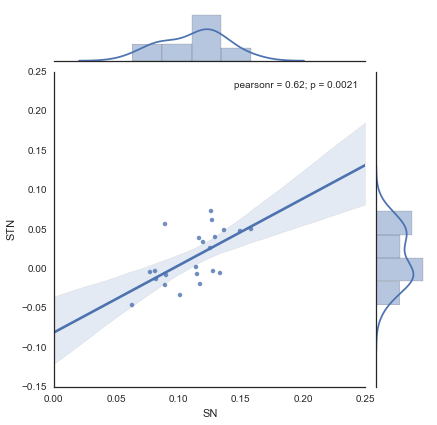

In [197]:
sns.jointplot(data = controls_a, x = 'SN', y='STN', kind = 'reg')

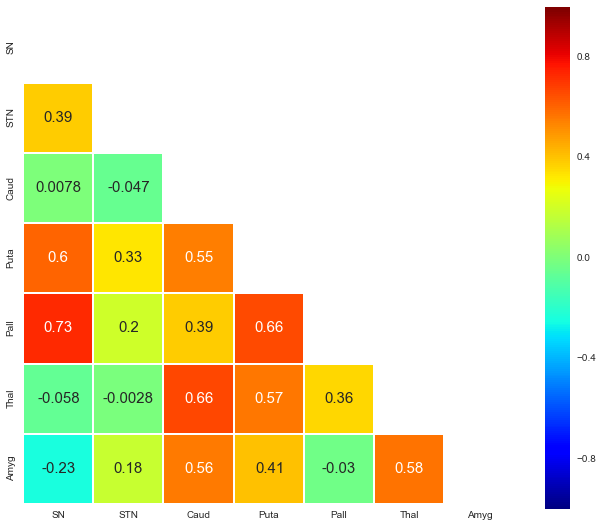

In [378]:
df = Xpatients_a
clinical_measures = [df.SN, 
                     df.STN,
                     df.Caud, 
                     df.Puta, 
                     df.Pall,
                     df.Thal,
                     df.Amyg,
                     ]
df = pd.concat(clinical_measures,  axis=1)


corr_p = df.corr('pearson')
mask = np.zeros_like(corr_p, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap = 'jet'
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_p,cmap=cmap, vmin = -1, vmax=1, mask=mask,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": 1}, ax=ax, annot = True, annot_kws={"size":15})

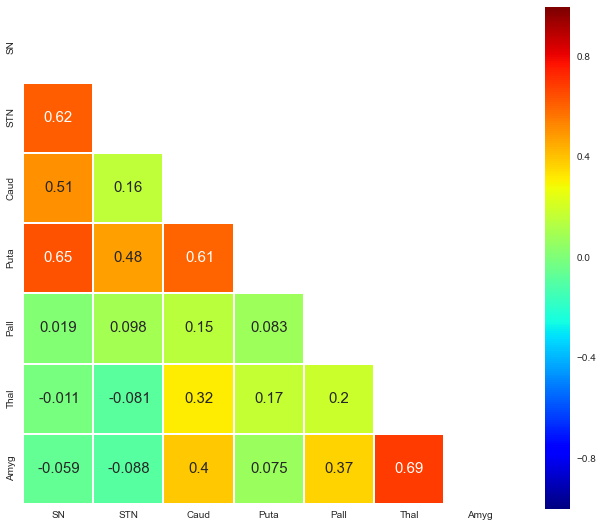

In [380]:
df = Xcontrols_a
clinical_measures = [df.SN, 
                     df.STN,
                     df.Caud, 
                     df.Puta, 
                     df.Pall,
                     df.Thal,
                     df.Amyg,
                     ]
df = pd.concat(clinical_measures,  axis=1)


corr = df.corr('pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap = 'jet'
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,cmap=cmap, vmin = -1, vmax=1, mask=mask,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": 1}, ax=ax, annot = True, annot_kws={"size":15})

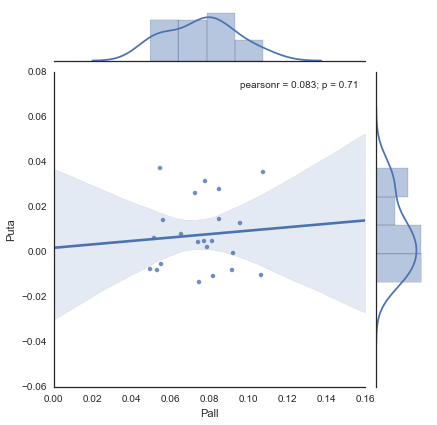

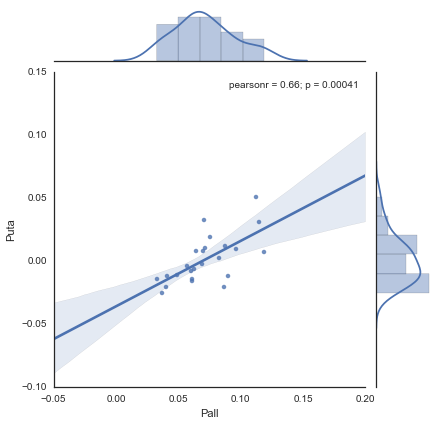

In [381]:
sns.jointplot(data = controls_a, x = 'Pall', y = 'Puta', kind = 'reg')
sns.jointplot(data = patients_a, x = 'Pall', y = 'Puta', kind = 'reg')

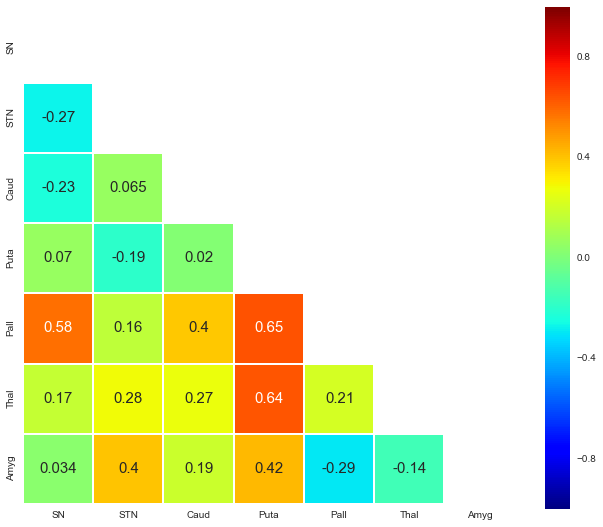

In [207]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap = 'jet'
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_p -corr,cmap=cmap, vmin = -1, vmax=1, mask=mask,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": 1}, ax=ax, annot = True, annot_kws={"size":15})

In [281]:
print ttest_ind(controls_a.Ferritin.dropna(), patients_a.drop(['SA5U'],axis = 0).Ferritin.dropna(), equal_var = False) 
print mannwhitneyu(controls_a.Ferritin.dropna(), patients_a.drop(['SA5U'],axis = 0).Ferritin.dropna()) 

(2.6952234799687398, 0.013715782573834991)
(92.0, 0.03779079909951779)


In [274]:
print np.mean(controls_a.Ferritin.dropna())
print np.mean(patients_a.Ferritin.dropna())


196.204444444
119.886470588


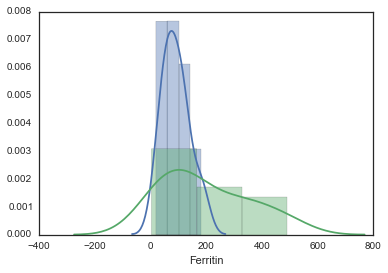

In [279]:
sns.distplot(patients_a.drop(['SA5U'],axis = 0).Ferritin.dropna())
sns.distplot(controls_a.Ferritin.dropna())

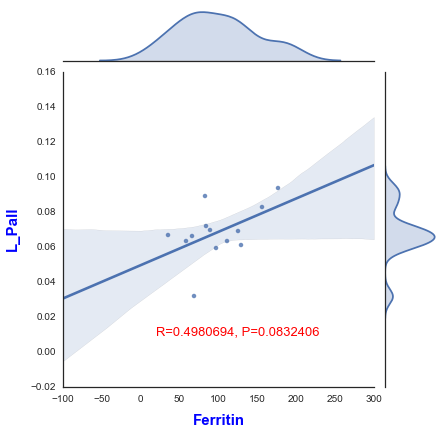

In [375]:
drop = drop_p #+ ['YU1P','CM5P']
df = Xpatients_a.drop(drop,axis =0)
plot_partial_correlation(data = df, x = 'Ferritin', y='L_Pall',
                         regressors=['Gender', 'FBER', 'SNR', 'CNR', 'QI1'], 
                         color=None, 
                         annotate=(20,0.01), 
                         fig_name=None, 
                         dpi=100, 
                         labels=True, 
                         jitter=None)

In [ ]:
spe

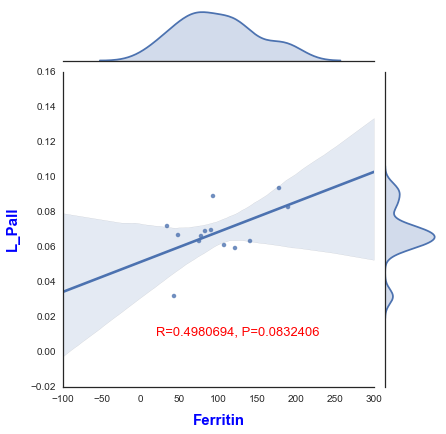

In [351]:
drop = drop_p + ['YU1P']
df = Xpatients_a.drop(drop,axis =0)
plot_partial_correlation(data = df, x = 'Ferritin', y='L_Pall',
                         regressors=['Gender', 'QI1'], 
                         color=None, 
                         annotate=(20,0.01), 
                         fig_name=None, 
                         dpi=100, 
                         labels=True, 
                         jitter=None)


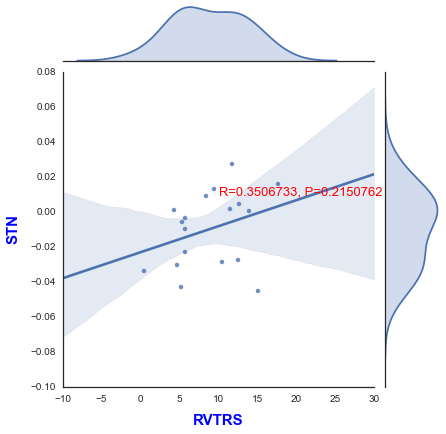

In [366]:
drop = drop_p + ['RA9P']
#drop = ['SA5U']
df = Xpatients_a.drop(drop,axis =0)
plot_partial_correlation(data = df, x = 'RVTRS', y='STN',
                         regressors=['Gender', 'Age'], 
                         color=None, 
                         annotate=(10,0.01), 
                         fig_name=None, 
                         dpi=100, 
                         labels=True, 
                         jitter=None)